# Setup

### Model Specifications (Modifiable)

In [1]:
model_title = "CNNpool_3dropout_15%n_5%w_ml" 

execution_profiles = ['default','sparse','CNN','local_patch','CNN_pool']
execution_profile = execution_profiles[4]

train_model = True # if this was set to false, the script would only plot and save figures based on your local model

mult_lr = True # this defines whether you want to train the model multiple times with different learning rate. If switched off, the model will use 0.0001 which is an optimum value by experimentation.

current_spread = 1 # this defines the Electric Receptive Field (ERF) spread

elec_side_dim = 8 # this defines a elec_side_dim*elec_side_dim 2D electrodes array, overlayed on top of the image

neu_side_dim = 16 # this defines a neu_side_dim*neu_side_dim 2D neuron array, overlayed on top of the image

noise = 0.05 # this defines the noise 
num_ftrmap = 0
if execution_profile == 'CNN_pool':
    num_ftrmap = 20

    kernal_size = 16
    
if execution_profile == 'sparse':
    _lambda = 0.000005 # this defines the penalty for 

if execution_profile == 'local_patch':
    kernal_size = 8

# options for activation functions are "linear", "2sig" and "ReLU"
activ_funcs_options = ["linear", "2sig","ReLU","sig"]
activ_func1 = activ_funcs_options[0] # This will be the activation function for layer1 (encoding layer)
activ_func2 = activ_funcs_options[3] # This will be the activation function for layer2 (LNL layer)
activ_func3 = activ_funcs_options[2] # This will be the activation function for layer2 (LNL layer)
af_array = [activ_func1,activ_func2,activ_func3]
# shift and magnitude defines the 2sig function shape
if activ_func1 == '2sig' or activ_func2 == '2sig':
    # go to this website to preview shape: https://www.desmos.com/calculator/ote7ccaecn
    shift = 9  # this defines the distance of the 2 sigmoid function from origin 
    magnitude = 0.5 # this defines the slope of the sigmoid function
# shift and magnitude defines the 2sig function shape
elif activ_func1 == 'sig' or activ_func2 == 'sig':
    # go to this website to preview shape: https://www.desmos.com/calculator/lls9xi44z4
    shift = 2   # this defines the distance of the sigmoid function from origin 
    magnitude = 2 # this defines the slope of the sigmoid function
else:
    shift = 0
    magnitude = 0
    

##### Model Specifications (fixed under most circumstances)

In [2]:
drop_rate = 0.3 # this is an optimum value and should not change unless it is certain that this value is negatively impacting the model

img_side_dim = 32 # image side dimension, assuming image is a square. If CIFAR is used, always set this to 32

activ_spread= 0 # this is an obsolete parameter, always set to 0 

n_epochs = 30 # this is an optimum value that works in most cases, only adjust if absolutely neccessary

##### import functions from scripts

In [3]:
import os
import numpy as np
import torch
import time
from LNL import define_save_LNL_model
from Full_model import define_model,train_and_save
from sparse_model_v2 import define_model_sparse,train_and_save_sparse
from image_receptive_field import visualize_img_recep,visualize_img_recon_recep
from compare_imgs import show_img_compare
from Full_model_CNN import define_model_CNN,train_and_save_CNN
from model_summary import show_generator,visualize_weights
from plot_error import show_error,comp_error
from Full_model_local_patch import define_model_local,train_and_save_local
from Full_model_CNN_poolfromlayer import define_model_CNN_pool,train_and_save_CNN_pool
from Pearson_correlation import Pearson_corr_comp
from pseudoinverse_visualisation import visualise_psuedo



##### Define model paths for saving

In [4]:
cwd = os.getcwd()
LNL_model_path = cwd+'/data/LNL_model.pth'
model_path = cwd+f'/data/model_{model_title}_lr = 0.0001.pth'
data_path = cwd + f'/data/NN_{model_title}_output.pkl'

##### Define the LNL section of the model and saves it for later use

In [5]:
# define the LNL layer with gaussian electrical receptive field
W_d = define_save_LNL_model(LNL_model_path,elec_side_dim, neu_side_dim, activ_spread, current_spread,FHWM=False)

Train the model and save the model for result demo
Default Model:

In [6]:
if execution_profile == 'default':
    AutoEncoder = define_model(elec_side_dim,neu_side_dim, LNL_model_path, drop_rate, af_array,shift,magnitude,noise)
    if train_model:  
        start_time = time.time()
        train_and_save(n_epochs,AutoEncoder,model_title,mult_lr)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time: {execution_time} seconds")

Default FC model with CNN as 1st layer

In [7]:
if execution_profile == 'CNN':
    AutoEncoder = define_model_CNN(elec_side_dim,neu_side_dim, LNL_model_path, drop_rate, af_array,shift,magnitude,noise,img_side_dim)
    if train_model:  
        start_time = time.time()
        train_and_save_CNN(n_epochs,AutoEncoder,model_title,mult_lr)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time: {execution_time} seconds")

CNN but pooling from feature maps

In [8]:
if execution_profile == 'CNN_pool':
    
    AutoEncoder = define_model_CNN_pool(elec_side_dim,neu_side_dim, LNL_model_path, drop_rate, af_array, shift,magnitude,noise,img_side_dim,num_ftrmap,kernal_size)
    if train_model:  
        start_time = time.time()
        train_and_save_CNN_pool(n_epochs,AutoEncoder,model_title,mult_lr)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time: {execution_time} seconds")

/home/ayacolyte/micromamba/envs/NN/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch [0/30], Loss: 0.3013
Epoch [10/30], Loss: 0.2416
Epoch [20/30], Loss: 0.2893
Epoch [0/30], Loss: 0.0274
Epoch [10/30], Loss: 0.0229
Epoch [20/30], Loss: 0.0240
Epoch [0/30], Loss: 0.0376
Epoch [10/30], Loss: 0.0247
Epoch [20/30], Loss: 0.0204
Epoch [0/30], Loss: 0.0680
Epoch [10/30], Loss: 0.0333
Epoch [20/30], Loss: 0.0273
Execution time: 3356.7710320949554 seconds


local patch custom layer

In [9]:
if execution_profile == 'local_patch':
    # code below generates a mask that forces weights other than those around the electrode to zero, hence introducing electrode with localised ERF
    input_size = img_side_dim**2
    output_size = elec_side_dim**2
    mask_np = np.zeros((input_size, output_size))
    for i in range(elec_side_dim): 
        for j in range(elec_side_dim):
            curr_elec = i*elec_side_dim + j  # zero based current electrode (first one is 0)
            rows = range(max(0, (4*i - 2)), min(img_side_dim,(4*i + 6)))
            for row in rows: 
                start = max(0,(4*j - 2))
                end =  min((4*j-2+kernal_size),img_side_dim)
                # Calculate indices
                indices = [row * img_side_dim + col for col in range(start, end)]
                mask_np[indices,curr_elec] = 1
    mask_torch = torch.from_numpy(mask_np)
    # define the model with this mask applied
    AutoEncoder = define_model_local(elec_side_dim,neu_side_dim, LNL_model_path, drop_rate, af_array,shift,magnitude,noise,img_side_dim, mask_torch)
    if train_model:  
        start_time = time.time()
        train_and_save_local(n_epochs,AutoEncoder,model_title,mult_lr)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time: {execution_time} seconds")

Sparse Model

In [10]:
if execution_profile == 'sparse':
    AutoEncoder = define_model_sparse(elec_side_dim,neu_side_dim, LNL_model_path, drop_rate, af_array,shift,magnitude,noise)
    if train_model:  
        start_time = time.time()
        train_and_save_sparse(n_epochs,AutoEncoder,model_title,_lambda,mult_lr = False)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time: {execution_time} seconds")

Result Demo

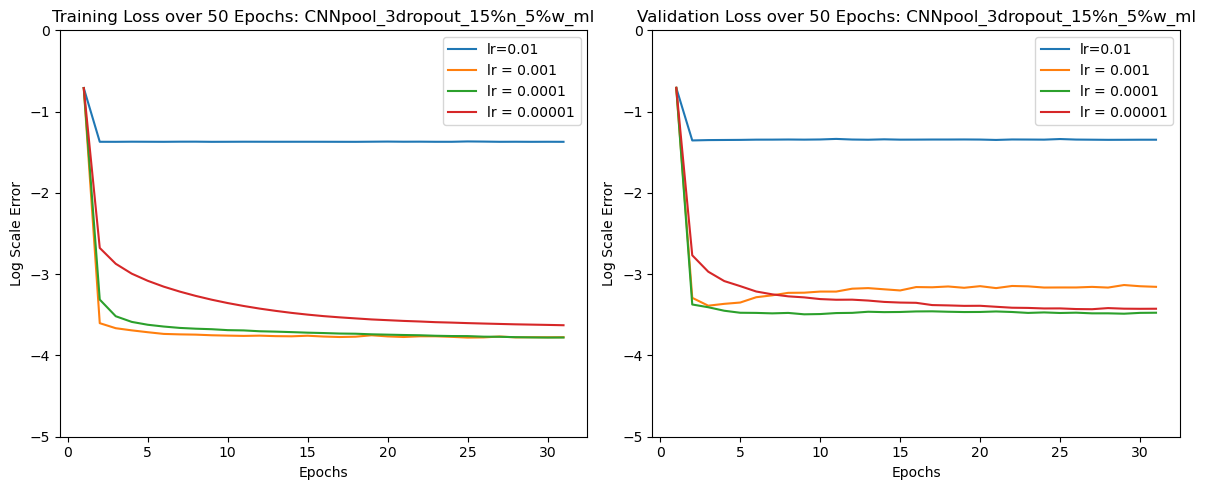

tensor([[0.4916, 0.4916, 0.4916, 0.4916],
        [0.2538, 0.0272, 0.0364, 0.0687],
        [0.2537, 0.0256, 0.0297, 0.0566],
        [0.2541, 0.0249, 0.0277, 0.0501],
        [0.2539, 0.0244, 0.0267, 0.0459],
        [0.2537, 0.0239, 0.0261, 0.0427],
        [0.2541, 0.0237, 0.0257, 0.0402],
        [0.2542, 0.0237, 0.0255, 0.0381],
        [0.2537, 0.0235, 0.0253, 0.0364],
        [0.2538, 0.0234, 0.0250, 0.0349],
        [0.2540, 0.0233, 0.0249, 0.0337],
        [0.2539, 0.0234, 0.0247, 0.0326],
        [0.2539, 0.0232, 0.0245, 0.0317],
        [0.2539, 0.0232, 0.0244, 0.0309],
        [0.2539, 0.0233, 0.0242, 0.0303],
        [0.2538, 0.0231, 0.0241, 0.0297],
        [0.2537, 0.0230, 0.0240, 0.0293],
        [0.2537, 0.0231, 0.0239, 0.0289],
        [0.2541, 0.0235, 0.0238, 0.0285],
        [0.2544, 0.0231, 0.0237, 0.0283],
        [0.2540, 0.0230, 0.0236, 0.0280],
        [0.2542, 0.0232, 0.0235, 0.0278],
        [0.2538, 0.0232, 0.0233, 0.0276],
        [0.2538, 0.0230, 0.0233, 0

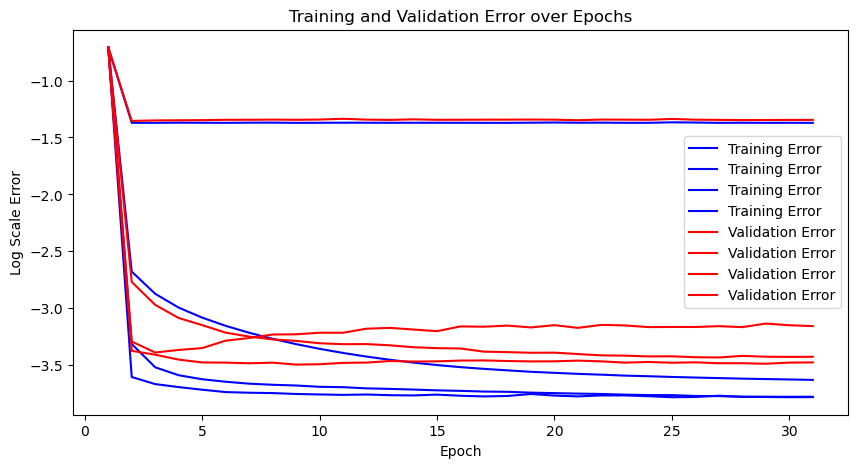

In [11]:
show_error(data_path,model_title)
comp_error(data_path,model_title)

torch.Size([31, 1]) torch.Size([31, 1])
torch.Size([31, 1]) torch.Size([31, 1])


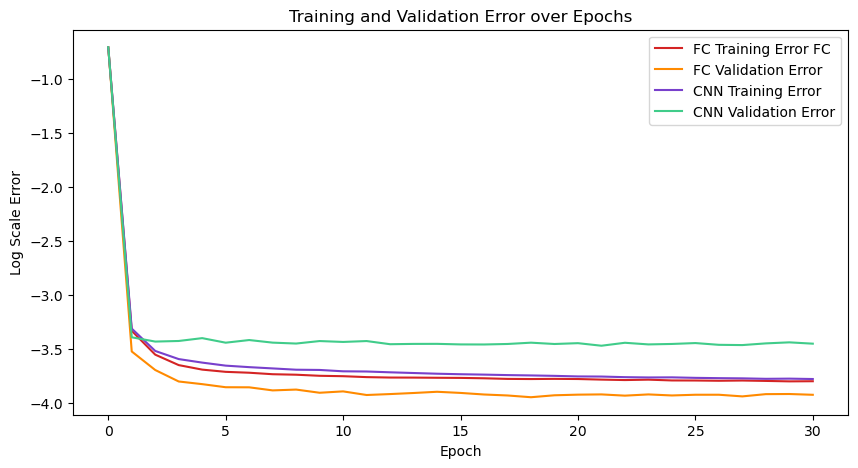

In [12]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
#from LNL import W_d
import math

import torch
import torch.nn as nn
cwd = os.getcwd()
model_title1 = 'fc_25%_noise_5%wnoise_30dropout_30epoch'
model_title2 = 'CNNpool_3dropout_15%n_5%w'
data_path1 = cwd + f'/data/NN_{model_title1}_output.pkl'
data_path2 = cwd + f'/data/NN_{model_title2}_output.pkl'

with open(data_path1, 'rb') as file1, open(data_path2, 'rb') as file2:
    data1 = pickle.load(file1)
    data2 = pickle.load(file2)
    #print(data2[0])
    N_epoch = 30
    x = np.arange(N_epoch + 1)
    #print(data[0])
    log_data1 = data1
    log_data2 = data2
    for i in range(data1[0].shape[1]) :
        for j in range(data1[0].shape[0]):

            log_data1[0][j,i] = math.log(data1[0][j,i])
            log_data2[0][j,i] = math.log(data2[0][j,i])
            #print(i)

    for i in range(data1[1].shape[1]) :
        for j in range(data1[1].shape[0]):

            log_data1[1][j,i] = math.log(data1[1][j,i])
            log_data2[1][j,i] = math.log(data2[1][j,i])
            #print(i)
    print(data1[0].shape, data2[0].shape)
    print(data1[1].shape, data2[1].shape)
    plt.figure(figsize=(10, 5))
    plt.plot(x,log_data1[0][:], label='FC Training Error FC', color=(0.83, 0.14, 0.14))  # Skip the first entry if it contains the mean
    plt.plot(x,log_data1[1][:], label='FC Validation Error', color=(1.00, 0.54, 0.00))  # Skip the first entry if it contains the mean
    plt.plot(x,log_data2[0][:], label='CNN Training Error', color=(0.47, 0.25, 0.80))  # Skip the first entry if it contains the mean
    plt.plot(x,np.squeeze(log_data2[1][:],0), label='CNN Validation Error', color=(0.25, 0.80, 0.54))  # Skip the first entry if it contains the mean
        
    plt.title('Training and Validation Error over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Log Scale Error')
    plt.legend()
    plt.savefig('Error Comparison between CNN and FC.png', format='png')
    plt.show()

feature map weights
Parameter containing:
tensor([[[[ 1.8780e-01, -9.2372e-01,  1.2492e-01,  ...,  1.3426e-01,
           -9.2861e-01, -1.5076e+00],
          [-4.7218e-01, -1.6995e+00, -5.3818e-01,  ..., -9.2788e-02,
            3.5401e-02,  1.6701e-01],
          [ 1.2779e-01, -1.6782e+00,  1.5967e+00,  ...,  3.2839e-02,
           -7.6407e-01,  1.4690e-01],
          ...,
          [ 6.5914e-01,  1.3023e+00,  4.3281e-01,  ...,  2.4700e-01,
            2.0788e-01,  1.2032e-01],
          [ 8.8020e-02,  6.7789e-01,  8.6508e-01,  ...,  2.0987e+00,
           -1.3474e-01,  5.2096e-01],
          [-1.8069e+00,  8.1326e-01,  6.1850e-01,  ...,  7.0437e-01,
            5.0053e-02, -1.5056e+00]],

         [[-1.0044e+00, -1.4283e+00, -2.7832e-02,  ...,  6.3821e-01,
            1.9085e+00, -2.7852e+00],
          [-1.5065e-01, -8.3269e-01,  1.2699e+00,  ..., -1.0415e+00,
           -9.1024e-01, -6.2995e-02],
          [ 9.8053e-01, -8.1740e-01, -1.1802e+00,  ..., -2.0246e+00,
           -1.18

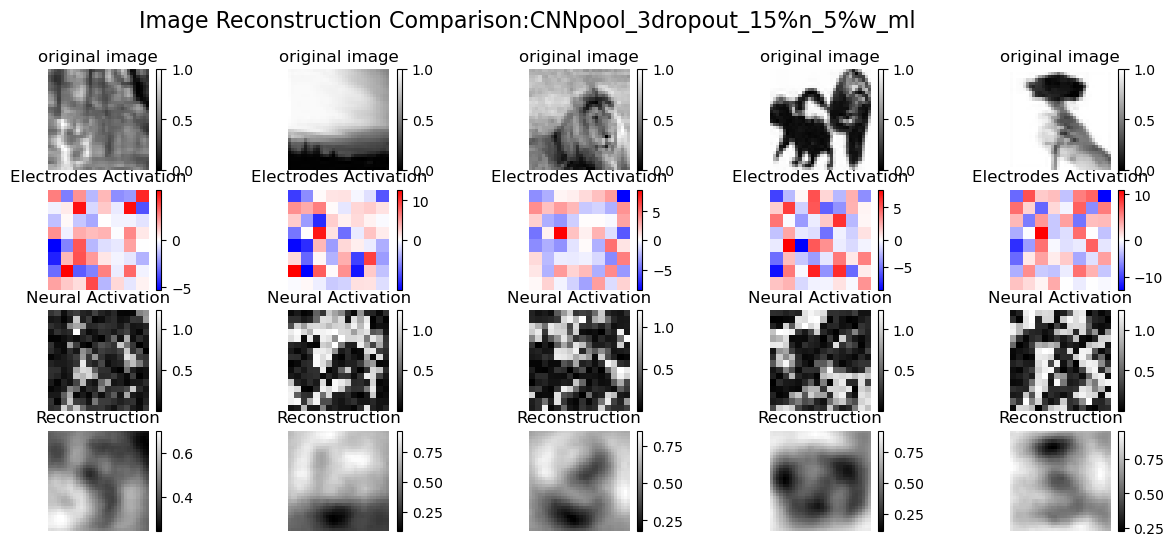

confirming
400.0


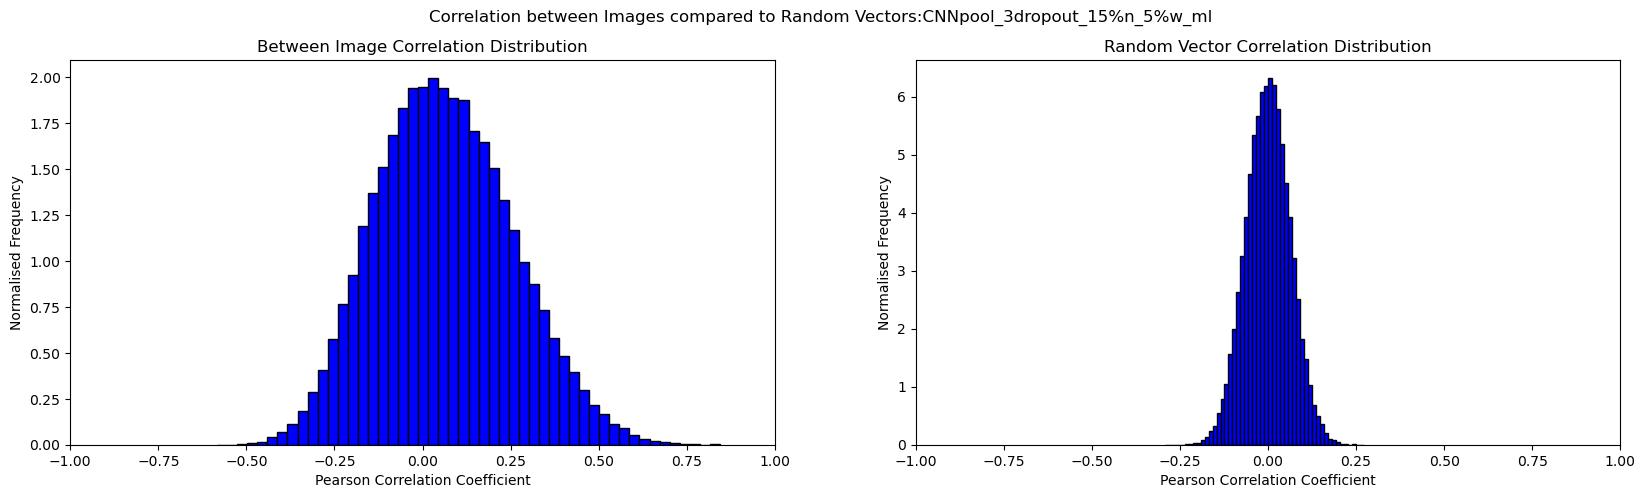

In [13]:
# import math
# import matplotlib.pyplot as plt
# import numpy as np
# import torch
output_test_flat, layer1_flat, layer2_flat,neu_maps = show_img_compare(model_path, AutoEncoder,model_title,execution_profile)

Pearson_corr_comp(neu_maps,model_title)
visualise_psuedo(model_path, AutoEncoder,model_title,execution_profile)
# layer1_flat = layer1_flat.detach().numpy()
# test_lyr2_flat = layer1_flat @ (W_d.transpose())


# sigmoid1 = 1/(1+np.exp(magnitude * (test_lyr2_flat + shift)))
# sigmoid2 = 1/(1+np.exp(-1*magnitude * (test_lyr2_flat - shift)))
# test_lyr2_flat = sigmoid1 + sigmoid2

# test_lyr2_flat = torch.tensor(test_lyr2_flat)



# side_dim = int(math.sqrt(test_lyr2_flat.shape[1]))
# test_lyr2 = test_lyr2_flat.view(test_lyr2_flat.shape[0],side_dim,side_dim)
# test_lyr2_np = test_lyr2.detach().numpy()

# lyr2 = layer2_flat.view(layer2_flat.shape[0],side_dim,side_dim)
# lyr2_np = lyr2.detach().numpy()

# # Create a figure with 2 subplots side by side
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# # Plotting on the first subplot
# img1 = ax1.imshow(test_lyr2_np[4],cmap='gray')

# # Plotting on the second subplot
# img2 = ax2.imshow(lyr2_np[4],cmap='gray')
# fig.colorbar(img1, ax=ax1, fraction=0.046, pad=0.04) 
# fig.colorbar(img2, ax=ax2, fraction=0.046, pad=0.04) 
# # Adjust the space between the plots
# plt.tight_layout()

# # Display the plots
# plt.show()

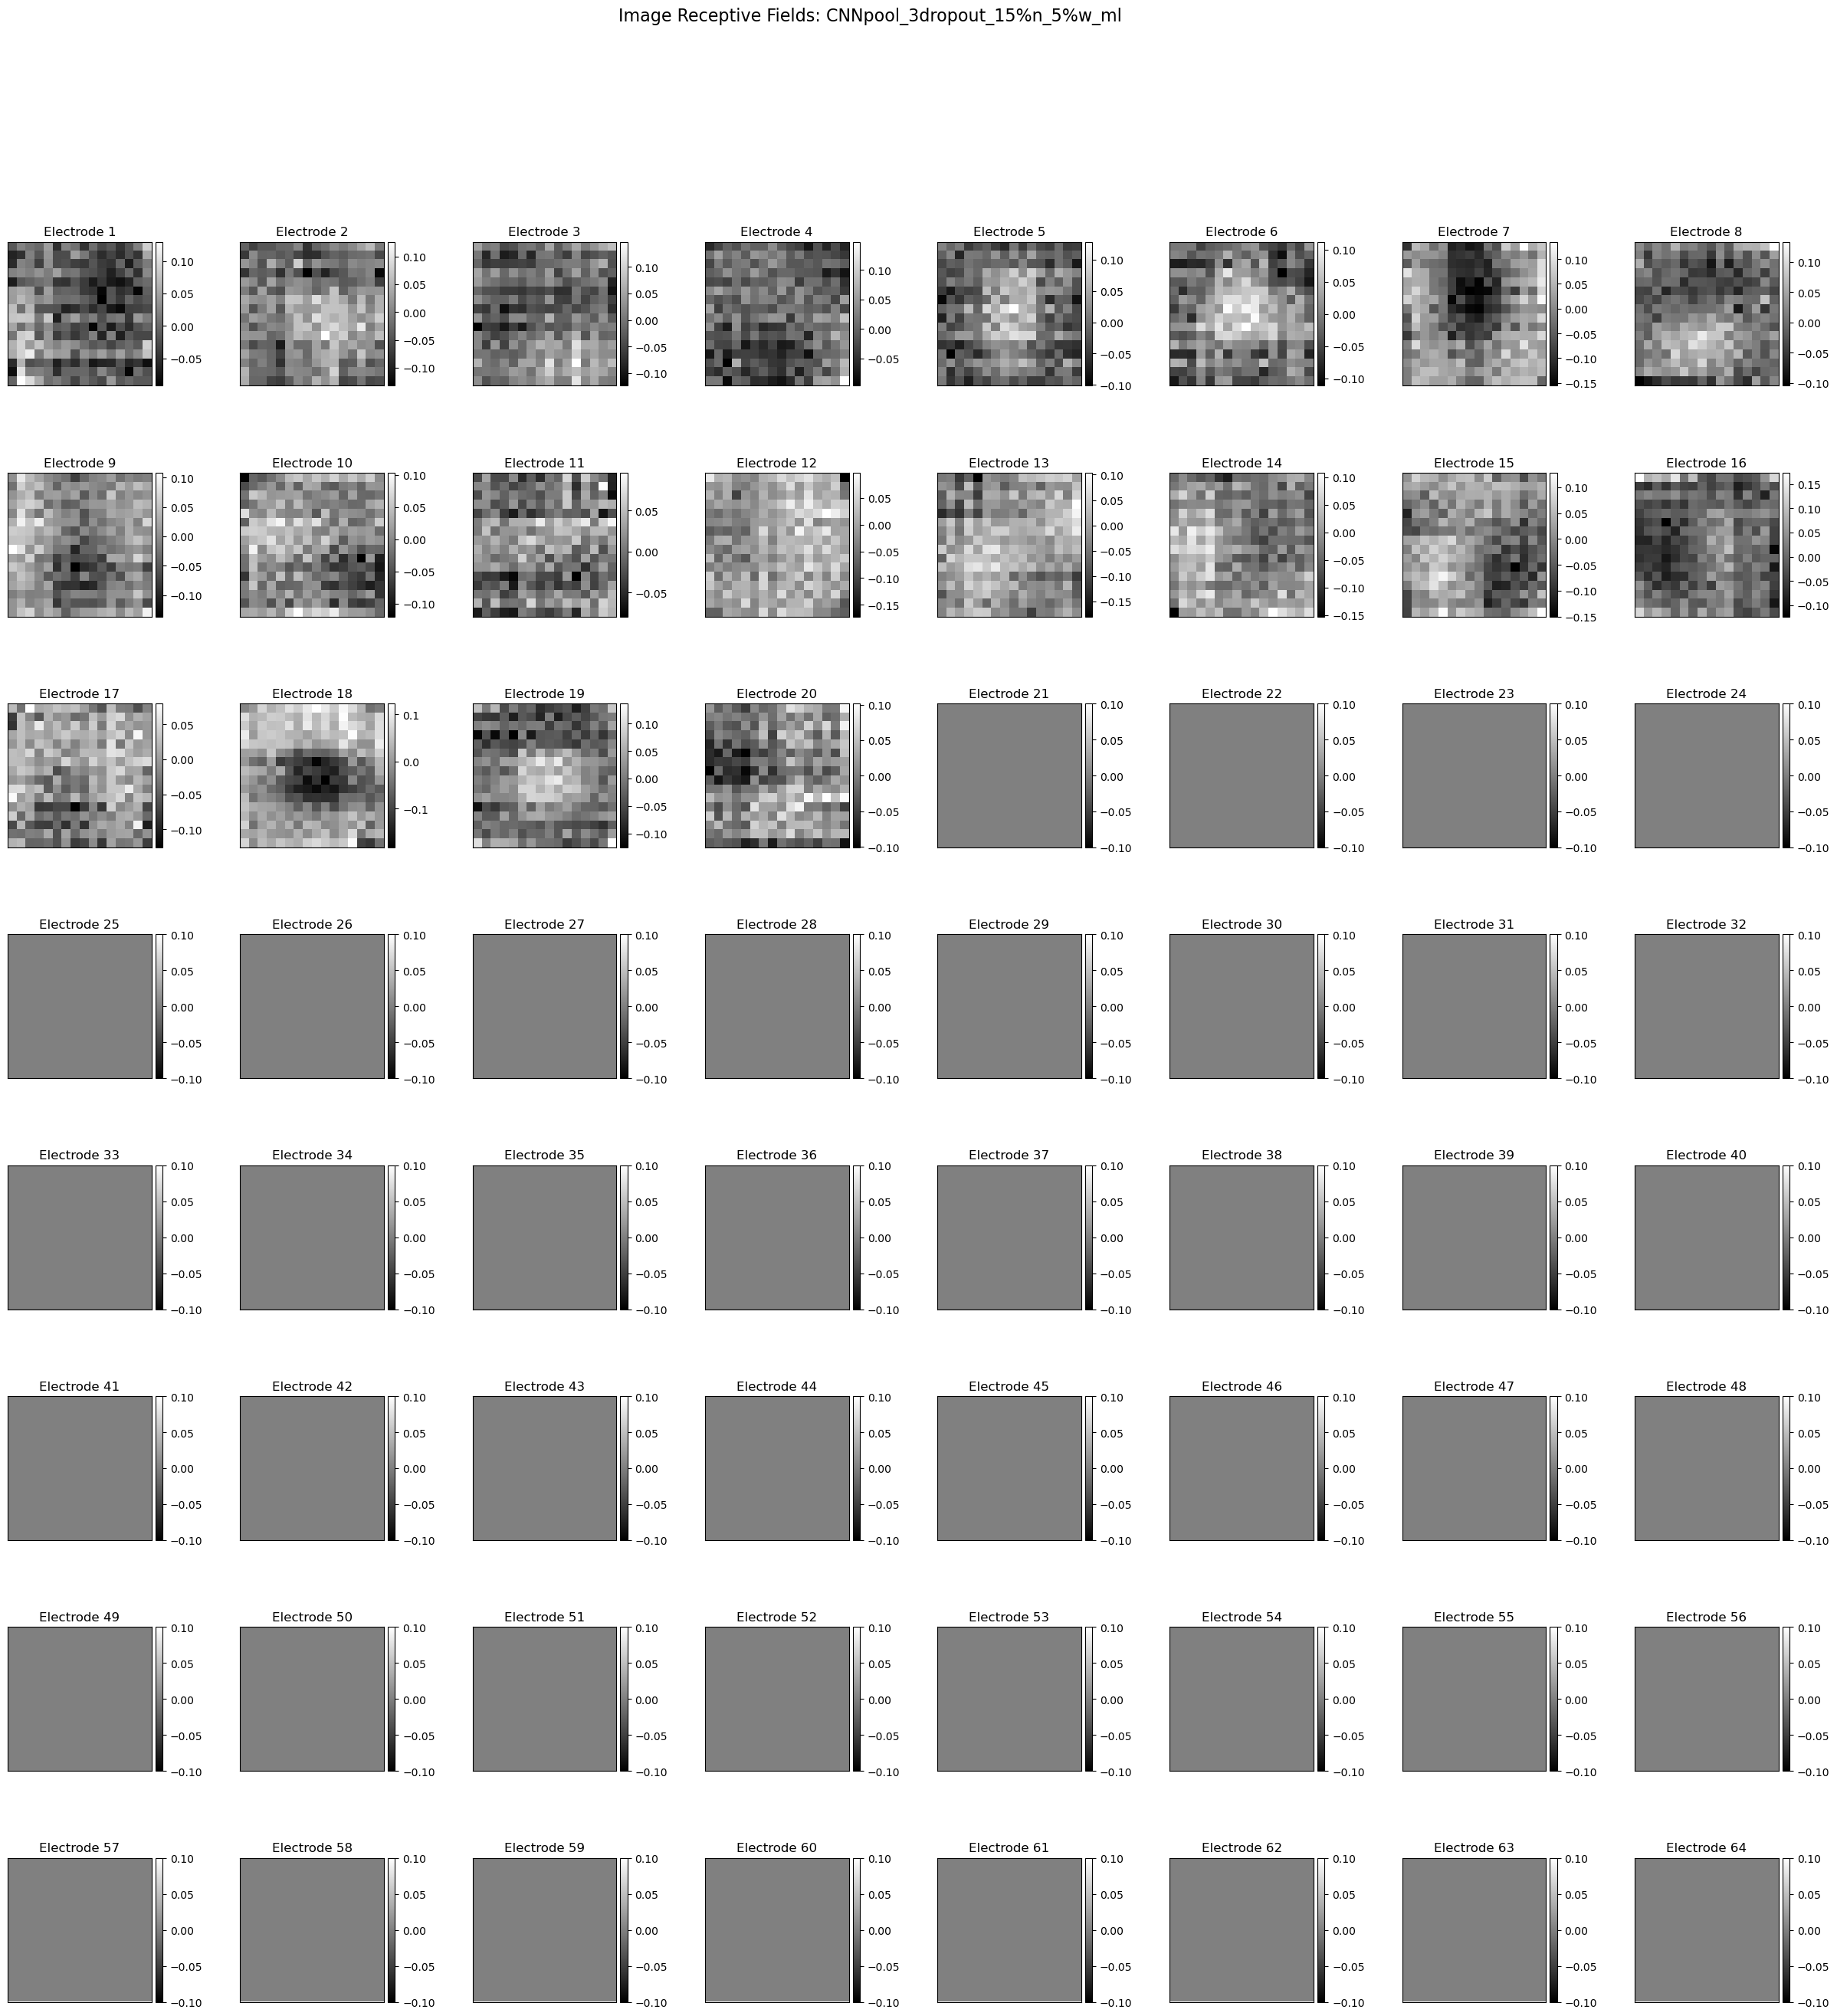

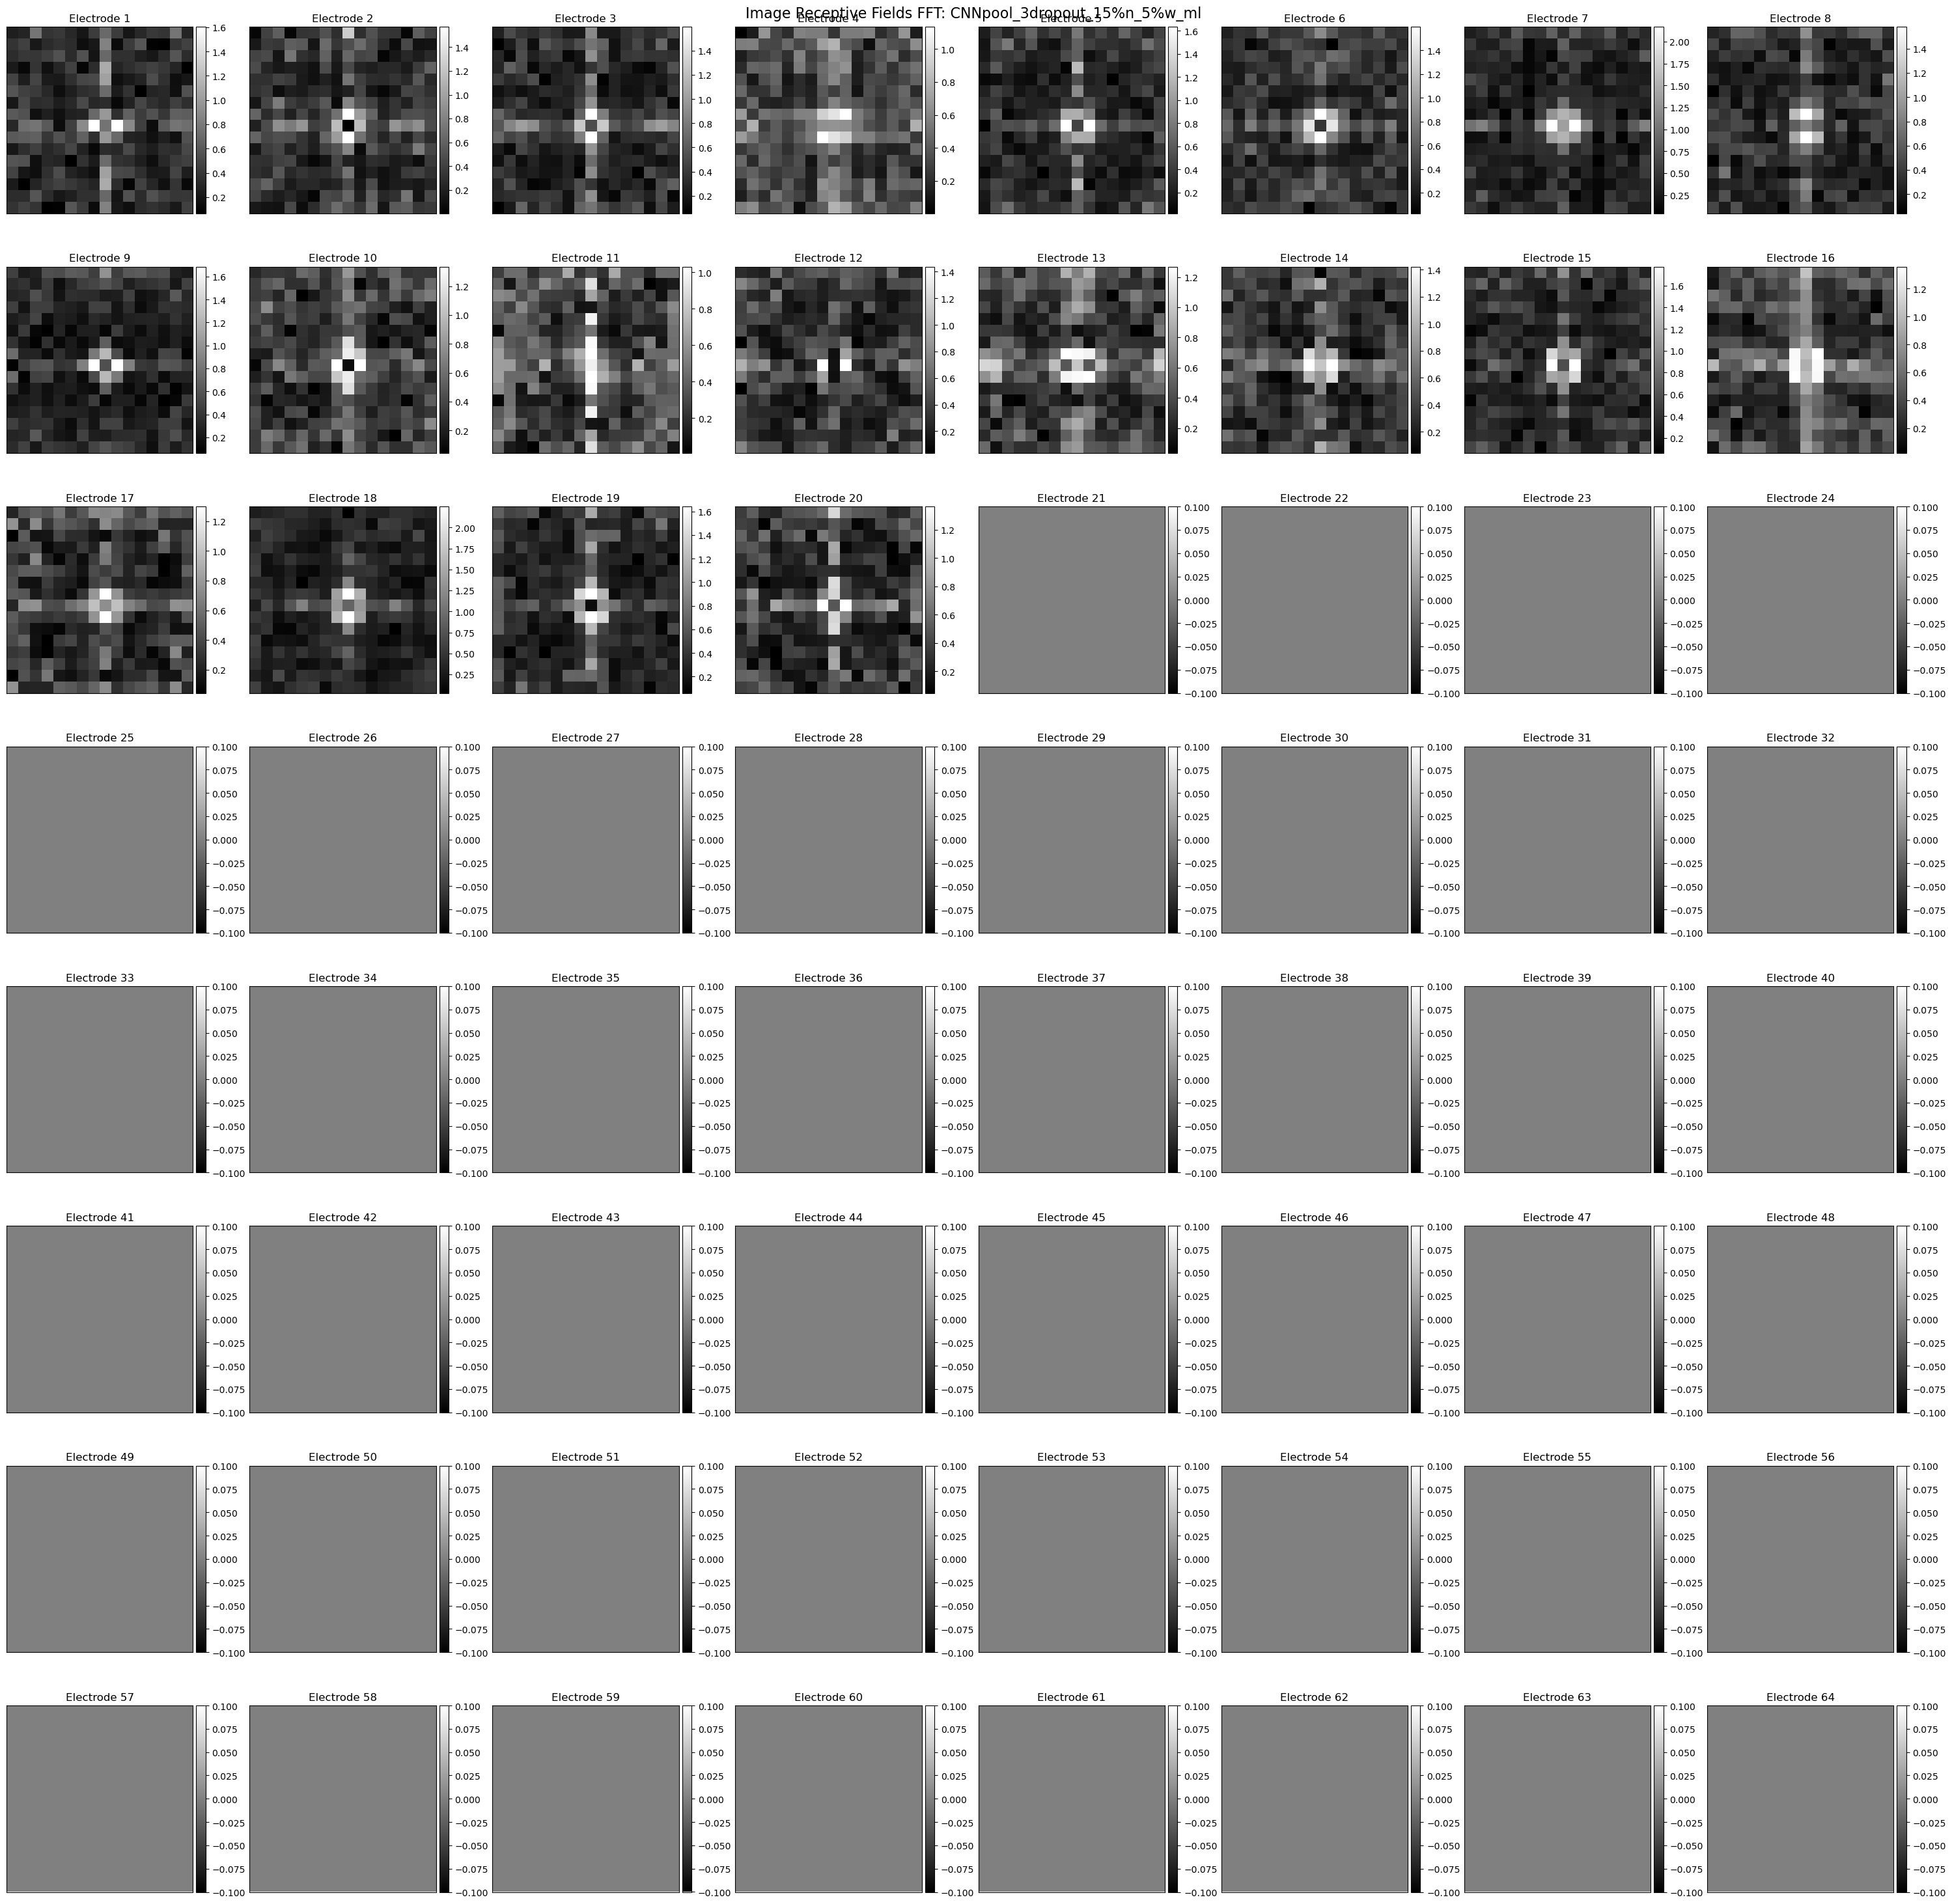

In [14]:
show_FFT = True
model_loaded = visualize_img_recep(model_path, AutoEncoder, img_side_dim,elec_side_dim,model_title,show_FFT,execution_profile)
#plot(model_loaded.layer3.weight.data.numpy())


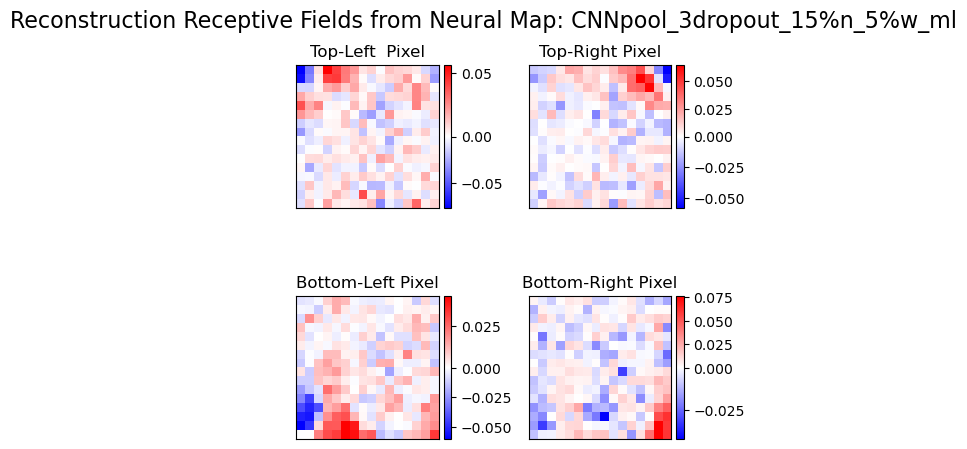

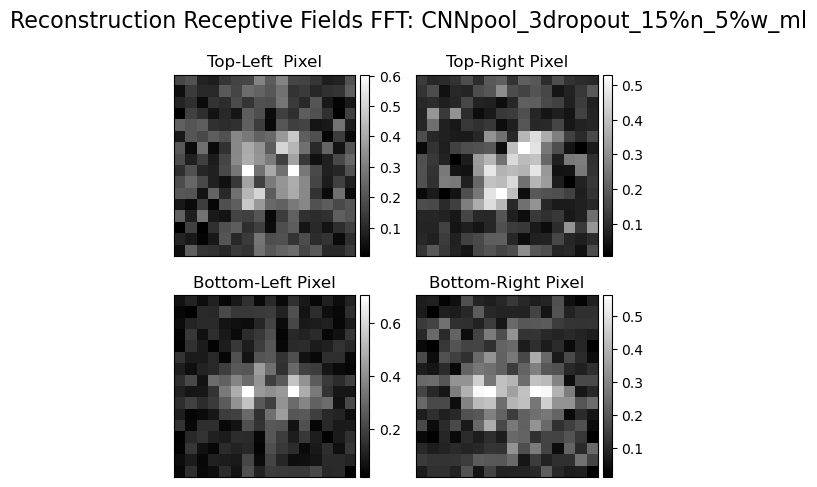

In [15]:
visualize_img_recon_recep(model_path, AutoEncoder, neu_side_dim, model_title,show_FFT)

In [16]:
if execution_profile != "CNN" and execution_profile != "CNN_pool":
    visualize_weights(AutoEncoder,model_path)

/home/ayacolyte/Capstone/model_summary.py:112: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[i].set_xlim(-1 * max(np.abs(np.max(gnrtr_mat)), np.abs(np.min(gnrtr_mat))),max(np.abs(np.max(gnrtr_mat)), np.abs(np.min(gnrtr_mat))))


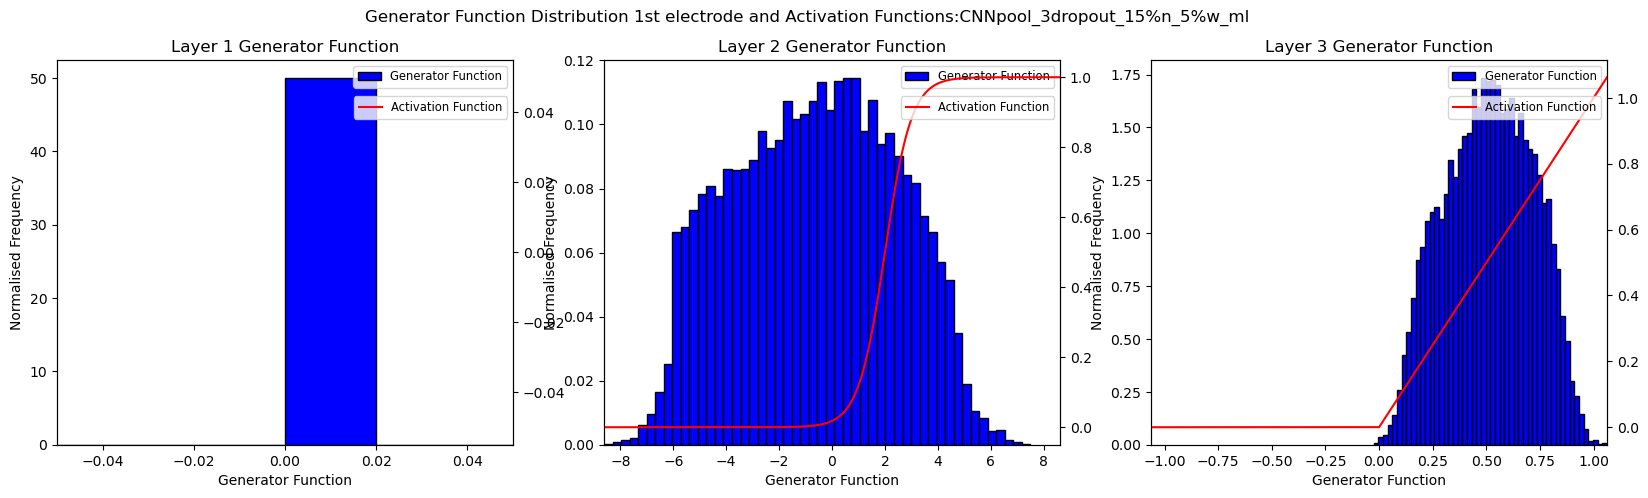

In [17]:
show_generator(model_path,AutoEncoder, af_array, magnitude, shift,model_title,execution_profile)